In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import string
import random
random.seed(100)

## Cleaning text and extracting feature vectors (Deliverable 1)

Two functions are defined: ```cleanText``` that removes punctuations and new lines, thereby cleaning the review; and ```extractWordFeatures``` creates a dictionary with counts of each word in a review

In [2]:
def cleanText(s):
    '''
    Returns string after removing punctuations and new lines, and separating concatenated words
    '''
    s = s.replace("-", " ")
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = s.lower().replace("\n", "").split()
    return " ".join(s)

def extractWordFeatures(x):
    '''
    Returns a feature vector from a supplied review
    '''
    return dict(Counter(x.split()))

## Loading Data  

Data is loaded from the text file, and the reviews and their labels are separated. An example is also shown below.

In [3]:
f = open("Dataset.txt", "r")
lines = f.readlines()
f.close()

data = [(cleanText(a.partition(" ")[2]), 1 if a[:2] == "+1" else -1) for a in lines]
random.shuffle(data)

print("Total number of datapoints: ", len(data))
print("Example datapoint before feature extraction: ", data[random.randint(0, 1000)])

Total number of datapoints:  3554
Example datapoint before feature extraction:  ('steven soderbergh doesnt remake andrei tarkovskys solaris so much as distill it', 1)


## Splitting the Dataset  

70% of the dataset is kept for training purposes, while the rest is used for validation.

In [4]:
# train-test split
cutoff = 0.7
num_train = round(len(data) * cutoff)

train_data = data[:num_train]
test_data = data[num_train:]

## Training and Prediction (Deliverable 2)  

Training examples are used to train the linear classifier using stochastic gradient descent over hinge loss. Training and Validation errors are plotted against iterations to verify. The results are shown below.

In [5]:
def learnPredictor(trainExamples, validationExamples, featureExtractor = extractWordFeatures, numIters = 50, eta = 0.05):
    '''
    Given |trainExamples| and |validationExamples| (each one is a list of (x,y) pairs), a
    |featureExtractor| to apply to x, and the number of iterations to train |numIters|, the step
    size |eta|, return the weight vector learned.
    '''
    
    # defining a lambda function to stringify classes
    stringify = lambda clas: "positive" if clas == 1 else "negative"
    
    # determining number of features
    m = set(" ".join([a[0] for a in trainExamples + validationExamples]).split())
    print("Number of features: ", len(m), "\n")
    
    # feature extraction for training and validation data 
    trainExamples = [(extractWordFeatures(a[0]), a[1]) for a in trainExamples]
    validationExamples = [(extractWordFeatures(a[0]), a[1]) for a in validationExamples]
    
    # displaying one example of extracted features
    random.shuffle(trainExamples)
    example = trainExamples[0]
    print("Example of an extracted feature vector:\n", example[0])
    print("Class for this example: ", stringify(example[1]), "\n")
    
    # intializing weight vector. Random initialization is chosen
    w = {word: random.random()/10 for word in m}

    # loss history for plotting
    trainErrorHistory = []
    validErrorHistory = []
    
    for i in range(numIters):
        trainError = 100 - computeAccuracy(trainExamples, w)
        validError = 100 - computeAccuracy(validationExamples, w)
        trainErrorHistory.append(trainError)
        validErrorHistory.append(validError)
        
        if (i%5 == 0):
            accuracy = computeAccuracy(trainExamples, w)
            print("After ", i, " iterations: ", 
                  "training error: ", trainError, 
                  ", validation error:", validError)
        
        # cautionary shuffle
        random.shuffle(trainExamples)
        
        # stochastic gradient descent. Update on each example
        for example in trainExamples:
            x = example[0]
            y = example[1]
            multiplier = gradientHinge(x, y, w)
            
            # updating
            for key in x:
                w[key] -= eta * multiplier * x[key]
            
    # plotting loss 
    plt.plot(range(1, len(trainErrorHistory) + 1), trainErrorHistory, "r-", label = "Training Error")
    plt.plot(range(1, len(validErrorHistory) + 1), validErrorHistory, "b-", label = "Validation Error")
    plt.title("Error Decay")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Error (%)")
    plt.legend()
    plt.show()
    
    print()
    # final accuracy on training data
    print("Training data accuracy: ", computeAccuracy(trainExamples, w), "%")
    
    #final accaccuracy on testing data
    print("Validation data accuracy: ", computeAccuracy(validationExamples, w), "%")
    
    return w

## Helper Functions

In [6]:
def hingeLoss(x, y, w):
    '''
    Returns the hinge loss for a single example
    '''
    return max((0, 1 - dot(x, w) * y))
        
def dot(dat, weight):
    '''
    Returns the dot product for a feature vector (dict) and a weight vector (dict)
    '''
    return sum([dat[key] * weight[key] for key in dat])

def gradientHinge(x, y, w):
    '''
    Returns the gradient multiplier of the hingle loss for a single example
    '''
    if dot(x, w) * y >= 1:
        return 0
    return -y

def computeLoss(data, w):
    '''
    Returns the average loss over a dataset
    '''
    m = len(data)
    return sum([hingeLoss(a[0], a[1], w) for a in data])/m

def computeAccuracy(data, w):
    '''
    Returns the accuracy of the predictions over a dataset
    '''
    m = len(data)
    true_labels = [a[1] for a in data]
    pred_labels = [dot(a[0], w) >= 0 for a in data] # >= sign denotes that a 0 score is taken as positive
    pred_labels = [1 if a else -1 for a in pred_labels]
    
    # counting correct predictions
    correct = 0
    for (a, b) in zip(pred_labels, true_labels):
        if a == b:
            correct += 1
            
    return correct * 100 / m

## Final Results

Number of features:  10862 

Example of an extracted feature vector:
 {'propelled': 1, 'not': 1, 'by': 2, 'characters': 1, 'but': 1, 'caricatures': 1}
Class for this example:  negative 

After  0  iterations:  training error:  50.08038585209003 , validation error: 50.469043151969984
After  5  iterations:  training error:  3.778135048231505 , validation error: 29.08067542213884
After  10  iterations:  training error:  0.3617363344051512 , validation error: 29.174484052532833
After  15  iterations:  training error:  0.040192926045023114 , validation error: 29.643527204502817
After  20  iterations:  training error:  0.0 , validation error: 29.268292682926827
After  25  iterations:  training error:  0.0 , validation error: 28.986866791744845
After  30  iterations:  training error:  0.0 , validation error: 28.611632270168855
After  35  iterations:  training error:  0.0 , validation error: 29.268292682926827
After  40  iterations:  training error:  0.0 , validation error: 28.611632270168855


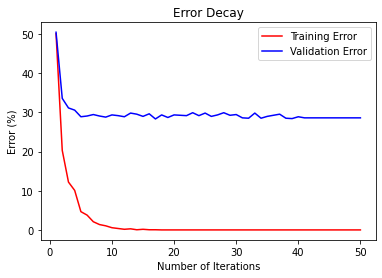


Training data accuracy:  100.0 %
Validation data accuracy:  71.38836772983115 %


In [7]:
w = learnPredictor(train_data, test_data)